In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import unicodedata
from vis import plot_missingness
from clean_raw_data import clean_and_output_csv, clean_gov_data, standardize_name

In [21]:
def standardize_name(name):
    """
    Standardize a given name by converting it to lowercase, removing accents, and stripping extra whitespace.

    Parameters:
    name (str): The name to be standardized.

    Returns:
    str: The standardized name.
    """
    # Ensure name is string 
    name = str(name)
    # Force lowercase
    name = name.lower()
    # Remove trailing and leading whitespace
    name = name.strip()
    # Unicode normalization
    name = unicodedata.normalize('NFKD', name).encode('ASCII', 'ignore').decode('ASCII')
    
    return name


def clean_gov_data(gov_df):
    gov_df = gov_df[:]
    # Remove rows that contain only null values
    gov_df = gov_df.dropna(how='all')
    # Rename columns to more descriptive names
    gov_df.columns = ['Region', 'District', 'Producer Name', 'Activity Type', 'President Name', 'Contact']
    # Extract the abbreviation (text inside parentheses) from 'Producer Name' and create a new column for it
    gov_df['Abbreviation Name'] = gov_df['Producer Name'].str.extract(r'\(([^)]+)\)')[0]
    # Remove the abbreviation text along with the parentheses from 'Producer Name'
    gov_df['Producer Name'] = gov_df['Producer Name'].str.replace(r'\s*\(.*?\)\s*', '', regex=True)
    
    return gov_df


def clean_and_output_csv(input_data, output_csv_path):
    """
    Clean the 'Producer Name' and 'Abbreviation Name' columns of a dataframe using the standardize_name function,
    and save the cleaned dataframe to a CSV file.

    Parameters:
    input_data (str or DataFrame): The path to the input CSV file or a DataFrame.
    output_csv_path (str): The path to save the cleaned CSV file.

    Returns:
    DataFrame: The cleaned dataframe.
    """
    # Load the data into a dataframe if input is a CSV path
    if isinstance(input_data, str):
        df = pd.read_csv(input_data)
    elif isinstance(input_data, pd.DataFrame):
        df = input_data.copy()
    else:
        raise ValueError("input_data must be a file path or a pandas DataFrame")

    # Assert that the required columns exist
    assert 'Producer Name' in df.columns, "The dataframe must contain the 'Producer Name' column."
    assert 'Abbreviation Name' in df.columns, "The dataframe must contain the 'Abbreviation Name' column."
    
    # Remove rows where both 'Producer Name' or 'Abbreviation Name' are None
    df = df.dropna(subset=['Producer Name', 'Abbreviation Name'], how='any')

    # Clean the 'Producer Name' and 'Abbreviation Name' columns
    df['Producer Name'] = df['Producer Name'].apply(standardize_name)
    df['Abbreviation Name'] = df['Abbreviation Name'].apply(standardize_name)

    # Drop the 'Country' column if it exists
    if 'Country' in df.columns:
        df = df.drop(['Country'], axis=1)

    # Output the cleaned dataframe to a CSV file
    df.to_csv(output_csv_path, index=False)

    return df    

In [22]:
producers_1 = pd.read_csv('data/raw/ivorian-cocoa-coop-registry-2017.csv')
producers_1 = clean_gov_data(producers_1)
producers_2 = pd.read_csv('data/raw/cocoa-suppliers-compiled-from-importers.csv')

producers_1_out_path = 'data/clean/ivorian-cocoa-coop-registry-2017.csv'
producers_2_out_path = 'data/clean/cocoa-suppliers-compiled-from-importers.csv'

producers_1 = clean_and_output_csv(producers_1, producers_1_out_path)
producers_2 = clean_and_output_csv(producers_2, producers_2_out_path)

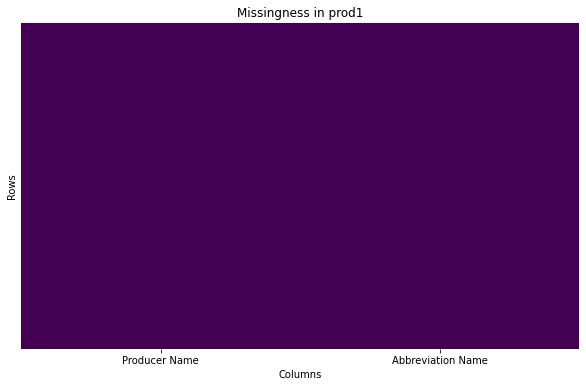

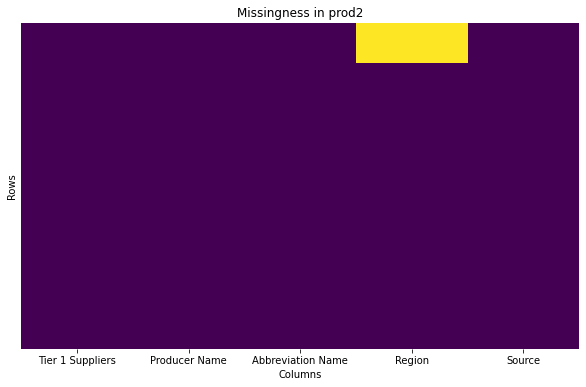

In [23]:
plot_missingness(producers_1[['Producer Name', 'Abbreviation Name']], 'prod1')
plot_missingness(producers_2, 'prod2')

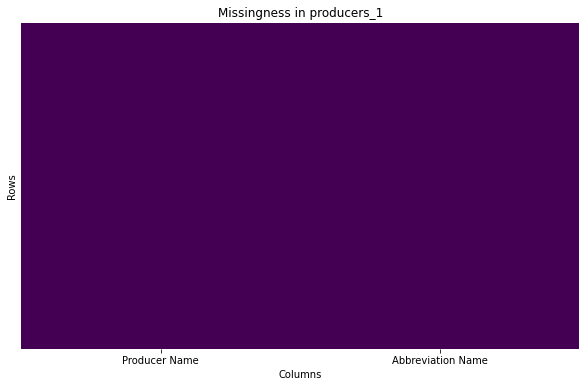

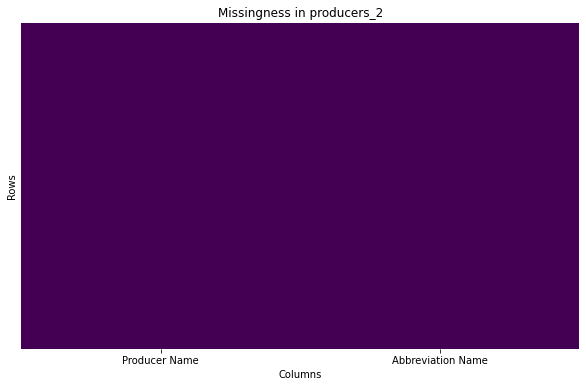

In [24]:
producers_1 = pd.read_csv('data/clean/ivorian-cocoa-coop-registry-2017.csv')
producers_2 = pd.read_csv('data/clean/cocoa-suppliers-compiled-from-importers.csv')

producers_1 = producers_1[['Producer Name', 'Abbreviation Name']]
producers_2 = producers_2[['Producer Name', 'Abbreviation Name']]
plot_missingness(producers_1, 'producers_1')
plot_missingness(producers_2, 'producers_2')

null_indices = producers_1[producers_1['Abbreviation Name'].isna()].index.tolist()